In [1]:
import numpy as np
from scipy import random
import networkx as nx
import pandas as pd
import random
import collections
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
#Model constructor
class HigherOrderNamingGame():
    
    def __init__(self, simplices, rule):
        
        #Structure
        self.simplices = simplices
        self.nodes = list({node for simplex in simplices for node in simplex}) 
        self.N = len(self.nodes)
        
        #Time
        self.t = 0
        
        #Rule
        self.rule = rule

    def SetInitialConditions(self, beta, p, n_A, verbose=False):
        
        #Game parameters
        self.beta = beta
        self.p = p
    
        #Opinions of the nodes (vocabularies)
        self.opinions = {}
        
        #Generating committed agents
        N_p = int(self.N*self.p) #number of committed agents
        #Randomly picking N_p committed agents
        committed = random.sample(self.nodes, N_p)
        #Setting up a committed dictionary
        #self.is_committed = {n:False for n in self.nodes}
        for n in self.nodes:
            if n in committed:
                #self.is_committed[n]=True
                #Assigning opinion "A" to committed agents
                self.opinions[n]=frozenset(["A"])
        
        #Calculating the number of agents holding n_A (not committed) from the density in input
        N_A = int(self.N*n_A)
        N_B = self.N-N_A-N_p
        #Creating a list of opinions to assign
        opinions_to_assign = ['A']*N_A + ['B']*N_B
        #Shuffling them
        random.shuffle(opinions_to_assign)
        #Agents left to be matched with opinions
        noncommitted = set(self.nodes) - set(committed)
        for n, o in zip(noncommitted, opinions_to_assign):
            self.opinions[n]=set(o)
        print(self.opinions)
        if verbose: print('Setup Done.', self.N, 'nodes,', "N_A:", N_A, "N_B:", N_B, "N_p:", N_p) 
    
    def AgreeOnSimplex(self, simplex, said_word):
        
        #Updating the simplex on the agreed word 
        for n in simplex:
            try: #There are also committed minorities which have frozensets!
                self.opinions[n].clear()
                self.opinions[n].add(said_word)
            except AttributeError: #It was committed
                pass

    def ListenersLearnWord(self, listeners, said_word):
        
        #Looping through the listeners
        for listener in listeners:
            try: #Trying to learn...
                self.opinions[listener].add(said_word)
            except AttributeError: #It was committed
                pass
                
    def play_on_simplex(self, simplex):
        
        #Selecting speaker and listeners at random
        random.shuffle(simplex)
        print(simplex)
        speaker = simplex[0]
        print(speaker)
        listeners = simplex[1:]
        
        #Selecting a random word to be said
        said_word = random.choice(list(self.opinions[speaker]))
        print(said_word)
        words_of_listeners = [self.opinions[listener] for listener in listeners]
        
        #Using the rule to get the words of listeners to be used for the agreement
        if self.rule=='union': 
            words_of_listeners_by_rule = set.union(*[set(w) for w in words_of_listeners])
        elif self.rule=='intersection':    
            words_of_listeners_by_rule = set.intersection(*[set(w) for w in words_of_listeners])
        
        #Trying to agree based on the rule and the communication efficiency beta
        if (said_word in words_of_listeners_by_rule):
            print('agreement possible')
            if (random.random() <= self.beta):
                print('beta condition satisfied')
                self.AgreeOnSimplex(simplex, said_word)
        else: #No agreement, but the said word is learned by the listeners
            self.ListenersLearnWord(listeners, said_word)
        print(self.opinions)
        print()
            
    def get_densities(self):
        single_opinion_counter = collections.Counter([list(opinions)[0] for opinions in self.opinions.values() if len(opinions)==1])
        n_Ap = single_opinion_counter["A"]/self.N
        n_B = single_opinion_counter["B"]/self.N
        n_AB = 1-n_Ap-n_B
        return n_Ap, n_B, n_AB

    def run(self, path, t_max=100, check_every=10, print_every=1):
        
        self.t_max = t_max
        
        #Opening file to save densities results
        densities_path = path + 'HONG_densities_N%i_beta%.4f_p%.2f.csv'%(self.N, self.beta, self.p)
        f = open(densities_path,'w')
        f.write('time,n_A+p,n_B,n_AB\n')
        
        while self.t <= self.t_max:
            self.t += 1
            #if self.t%print_every==0: print('t=%i'%self.t)
                
            ######### THIS IS FOR PLAYING ALWAYS ON ALL SIMPLICES AT EACH TIME #########
            #Reshuffling the sequence of simplices
            #random.shuffle(self.simplices)
            
            #Looping over each simplex and playing
            #for simplex in self.simplices:
                #self.play_on_simplex(simplex)
            ############################################################################
            
            #Playing on a random simplex 
            simplex = random.choice(self.simplices)
            self.play_on_simplex(simplex)
                
            #Storing the values every check_every time steps:
            if self.t%check_every==0:
                n_Ap, n_B, n_AB = self.get_densities()
                line = "%i,%.3f,%.3f,%.3f\n"%(self.t, n_Ap, n_B, n_AB)
                f.write(line)
                print('wrote line')
                
                #Also checking if we reached the absorbing state:
                if n_Ap==1 or n_B==1:
                    f.close()   
                    print('DONE! Reached the absorbing state.')
                    return None
                
        f.close()    
        print('DONE! Run out of time...')

In [23]:
simplices = [[0,3], [1,3], [2,3], [0,1,2], [0,1,2,3]]
rule = 'intersection'

beta = 0.5
p = 0.25
n_A = 0

output_path = 'outputs/'
t_max = 20
check_every = 1

HONG = HigherOrderNamingGame(simplices, rule)
HONG.SetInitialConditions(beta=beta, p=p, n_A=n_A, verbose=True)
HONG.run(output_path, t_max, check_every)

{2: frozenset({'A'}), 0: {'B'}, 1: {'B'}, 3: {'B'}}
Setup Done. 4 nodes, N_A: 0 N_B: 3 N_p: 1
[3, 0]
3
B
agreement possible
{2: frozenset({'A'}), 0: {'B'}, 1: {'B'}, 3: {'B'}}

wrote line
[3, 2]
3
B
{2: frozenset({'A'}), 0: {'B'}, 1: {'B'}, 3: {'B'}}

wrote line
[2, 0, 1]
2
A
{2: frozenset({'A'}), 0: {'B', 'A'}, 1: {'B', 'A'}, 3: {'B'}}

wrote line
[3, 2]
3
B
{2: frozenset({'A'}), 0: {'B', 'A'}, 1: {'B', 'A'}, 3: {'B'}}

wrote line
[2, 1, 0]
2
A
agreement possible
{2: frozenset({'A'}), 0: {'B', 'A'}, 1: {'B', 'A'}, 3: {'B'}}

wrote line
[3, 1]
3
B
agreement possible
beta condition satisfied
{2: frozenset({'A'}), 0: {'B', 'A'}, 1: {'B'}, 3: {'B'}}

wrote line
[3, 2]
3
B
{2: frozenset({'A'}), 0: {'B', 'A'}, 1: {'B'}, 3: {'B'}}

wrote line
[2, 3]
2
A
{2: frozenset({'A'}), 0: {'B', 'A'}, 1: {'B'}, 3: {'B', 'A'}}

wrote line
[1, 3, 2, 0]
1
B
{2: frozenset({'A'}), 0: {'B', 'A'}, 1: {'B'}, 3: {'B', 'A'}}

wrote line
[2, 1, 0]
2
A
{2: frozenset({'A'}), 0: {'B', 'A'}, 1: {'B', 'A'}, 3: {'B', 'A

In [24]:
df = pd.read_csv('outputs/HONG_densities_N4_beta0.5000_p0.25.csv')

<AxesSubplot:xlabel='time'>

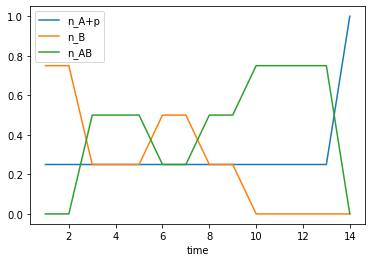

In [25]:
df.plot(x='time')